<h1>Use odm2api to connect to an odm2 database, create a dropdownlist to pick a time series result and visualize them</h1>
<p>1) First load standard python libraries</p>

In [1]:
%matplotlib inline

import sys
import os
import pprint
import numpy
import pandas as pd
import getpass
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import DateFormatter
from IPython.display import display, HTML
import ipywidgets as widgets

<p>2) Next load odm2api components we will use </p>

In [2]:
from odm2api.ODMconnection import dbconnection
import odm2api.ODM2.services.readService as odm2
from odm2api.ODM2.models import *

<p>3) now connect to the database and instantiate the read service </p>

In [3]:
#print("Enter your ODM2 username") 
container = widgets.Box() # would be nice If I could get a container to hold the 
# user name and password prompt, getpass doesn't seem to play well with the other 
# widgets though
username_text = widgets.Text(
    value='', placeholder='Enter username',
    description='', disabled=False)
username_output_text = widgets.Text(
    value='', placeholder='Enter username',
    description='Username',disabled=False)
database_address_text = widgets.Text(
    value='', placeholder='Enter database address',
    description='',disabled=False)
database_address_output_text = widgets.Text(
    value='',placeholder='Enter database address',
    description='database address',disabled=False)
database_text = widgets.Text(
    value='', placeholder='Enter database name',
    description='', disabled=False)
database_output_text = widgets.Text(
    value='', placeholder='Enter database name',
    description='database name', disabled=False)
def bind_username_to_output(sender):
    username_output_text.value = username_text.value
def bind_database_address_to_output(sender):
    database_address_output_text.value = database_address_text.value
def bind_database_to_output(sender):
    database_output_text.value = database_text.value     
    
def login(sender):
    #print('Database address : %s, Username: %s, database name: %s' % (
    #    database_address_text.value, username_text.value, database_text.value))
    container.close()    
    
username_text.on_submit(bind_username_to_output)
login_btn = widgets.Button(description="Login")
login_btn.on_click(login)
container.children = [username_text,database_address_text, database_text, login_btn]
container

Box(children=(Text(value=u'', placeholder=u'Enter username'), Text(value=u'', placeholder=u'Enter database address'), Text(value=u'', placeholder=u'Enter database name'), Button(description=u'Login', style=ButtonStyle())))

In [4]:
print("enter your password: ")
p = getpass.getpass()

enter your password: 
········


In [5]:
session_factory = dbconnection.createConnection('postgresql', database_address_text.value, database_text.value, 
                                                username_text.value, p) 

read = odm2.ReadODM2(session_factory)

<p>4) Now get some time series results based on the action related to them </p>
<p>&nbsp;&nbsp;&nbsp;&nbsp;a) In this case the result contains a featureaction and featureactions contain an action </p>
<p>5) Next loop through the results and create a string based representation of a result.</p>
<p>6) Create a dropdown list in order to pick a time series result</p>

In [6]:
#featureaction = 1700
results = read.getResults(actionid=30)
resultids = []
resultnames = {}

def print_result_name(result):
    print result
def on_change(change):
    print(change['new'])
    
for r in results:
    #print(r.ResultID)
    resultids.append(str(r.ResultID))
    detailr = read.getDetailedResultInfo(resultTypeCV = 'Time series coverage',resultID=r.ResultID)
    for detail in detailr:
        namestr = str(detail.SamplingFeatureCode + "- " + detail.MethodCode + "- "+ detail.VariableCode + "- " + detail.UnitsName)
        
        resultnames[namestr]=  detail.ResultID
    #print(detailr.Methods)
print(resultids)
resultWidget = widgets.Dropdown(options=resultnames)
rwidget = widgets.interactive(print_result_name,result=resultWidget)
rwidget.observe(on_change)
display(rwidget)

['16524', '16525', '16543', '16544', '16547', '16546', '16550', '16551', '16552', '16553', '16554', '16555']


interactive(children=(Dropdown(description=u'result', options={'Icacos Pulse-RI- SUNA- Absorbance-350- Absorbance units': 16551L, 'Icacos Pulse-RI- SUNA- Light Average- Counts': 16553L, 'Icacos Pulse-RI- SUNA- Absorbance-254- Absorbance units': 16550L, 'Quebrada Sonadora- SUNA- Nitrate (NO3)- milligrams per liter': 16525L, 'Quebrada Sonadora- SUNA- Absorbance-254- Absorbance units': 16543L, 'Quebrada Sonadora- SUNA- Nitrate (NO3)- Micromolar': 16524L, 'Quebrada Sonadora- SUNA- Light Average- Counts': 16547L, 'Quebrada Sonadora- SUNA- Bromide- milligrams per liter': 16546L, 'Quebrada Sonadora- SUNA- Absorbance-350- Absorbance units': 16544L, 'Icacos Pulse-RI- SUNA- Nitrate (NO3)- Micromolar': 16554L, 'Icacos Pulse-RI- SUNA- Nitrate (NO3)- milligrams per liter': 16555L, 'Icacos Pulse-RI- SUNA- Bromide- milligrams per liter': 16552L}, value=16551L), Output()), _dom_classes=('widget-interact',))

<p>7) Use the selected value to retrieve the time series values</p>

In [7]:
print(resultWidget.value)
ids = [resultWidget.value]
selectedResult = read.getDetailedResultInfo(resultTypeCV = 'Time series coverage',resultID=resultWidget.value)
SUNAResultValues = read.getResultValues(resultids=ids, starttime='2016-8-1', 
                                                 endtime= '2016-8-30')



16525


8) Set valuedatetime as an index in the pandas dataframe. 

In [8]:
SUNAResultValues.set_index('valuedatetime', inplace=True)

<p>9) Format a plot and plot the selected time series</p>

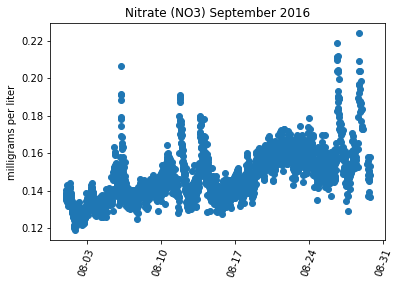

In [9]:
dateFmt = DateFormatter('%m-%d')
fig, ax = plt.subplots()
ax.xaxis_date()
#SUNAResultValues["valuedatetimed"] = pd.to_datetime(SUNAResultValues["valuedatetime"])
#SUNAResultValues["month-day"] = SUNAResultValues['valuedatetimed'].dt.strftime('%m-%d %H:%M') 
#print(SUNAResultValues["month-day"])
#mpl.dates.date2num(df.index.to_pydatetime())
#SUNAResultValues["valuedatetimed"]

ax.plot_date(  mpl.dates.date2num(SUNAResultValues.index.to_pydatetime()), SUNAResultValues['datavalue'])
ax.xaxis.set_major_formatter(dateFmt)

plt.xticks(rotation=70)
for result in selectedResult:
    plt.title(str(result.VariableCode) + ' September 2016')
    plt.ylabel(result.UnitsName)


<p>10) Use the numpy libaray to calculate some statistics about the time series</p> 
<p>11) Dynamically create histogram bins based on the time series standard deviation and graph the histogram</p>

count    2386.000000
mean        0.147180
std         0.013481
min         0.118755
25%         0.137461
50%         0.145097
75%         0.155608
max         0.224183
Name: datavalue, dtype: float64

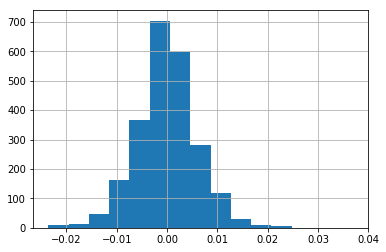

In [10]:
SUNAResultValues['datavalue'].diff().hist(alpha=1, bins=15)
SUNAResultValues['datavalue'].describe()